In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted')
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 7, 4

import random
from utils.helpers import load_data, get_features, plot_random_patient_recordings

# Importing Data

In [2]:
directories = ['./physionet.org/files/challenge-2019/1.0.0/training/training_setA', 
               './physionet.org/files/challenge-2019/1.0.0/training/training_setB']

dataset, record_lengths = load_data(directories=directories, target_label='SepsisLabel')
# X_train, y_train, record_lengths = load_data(directories=directories, target_label='SepsisLabel', x_train_y_train=True)

Loaded 20336 records from ./physionet.org/files/challenge-2019/1.0.0/training/training_setA.
Loaded 20000 records from ./physionet.org/files/challenge-2019/1.0.0/training/training_setB.
Total number of records: 40336 (Check using: df['PatientID'].nunique())
Memory consumed: 497.38 MB


In [3]:
print(dataset.shape)
dataset.head()

(1552210, 42)


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,PatientID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.02,1.0,NaN,NaN,-0.03,1.0,0.0,0
1,70.0,97.5,NaN,96.0,62.5,52.5,21.5,NaN,NaN,NaN,...,NaN,NaN,83.02,1.0,NaN,NaN,-0.03,2.0,0.0,0
2,72.0,98.0,37.67,119.0,81.0,62.0,22.0,NaN,NaN,NaN,...,NaN,NaN,83.02,1.0,NaN,NaN,-0.03,3.0,0.0,0
3,81.0,97.0,NaN,136.0,98.0,74.0,18.0,NaN,NaN,NaN,...,NaN,NaN,83.02,1.0,NaN,NaN,-0.03,4.0,0.0,0
4,86.0,NaN,NaN,104.0,71.0,56.5,20.5,NaN,NaN,NaN,...,NaN,NaN,83.02,1.0,NaN,NaN,-0.03,5.0,0.0,0


# Initial Analysis

## Target Distribution

In [4]:
def plot_target_classes():
    start_length, ones, zeros = 0, 0, 0
    for idx, length in enumerate(record_lengths):
        end_length = start_length + length    
        if dataset['SepsisLabel'][start_length:end_length].isin([1.0]).any():
            ones += 1
        else:
            zeros += 1
        start_length = end_length
        
    data = {'Category': ['Sepsis', 'Non-Sepsis'], 'Count': [ones, zeros]}
    plot_df = pd.DataFrame(data)
    ax = sns.barplot(x='Category', y='Count', data=plot_df)
    plt.title('Counts of 1.0s and 0.0s in SepsisLabel')
    total = ones + zeros
    for p in ax.patches:
        percentage = '{:.3f}%'.format(100 * p.get_height() / total)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), fontsize='x-small', 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    plt.show()

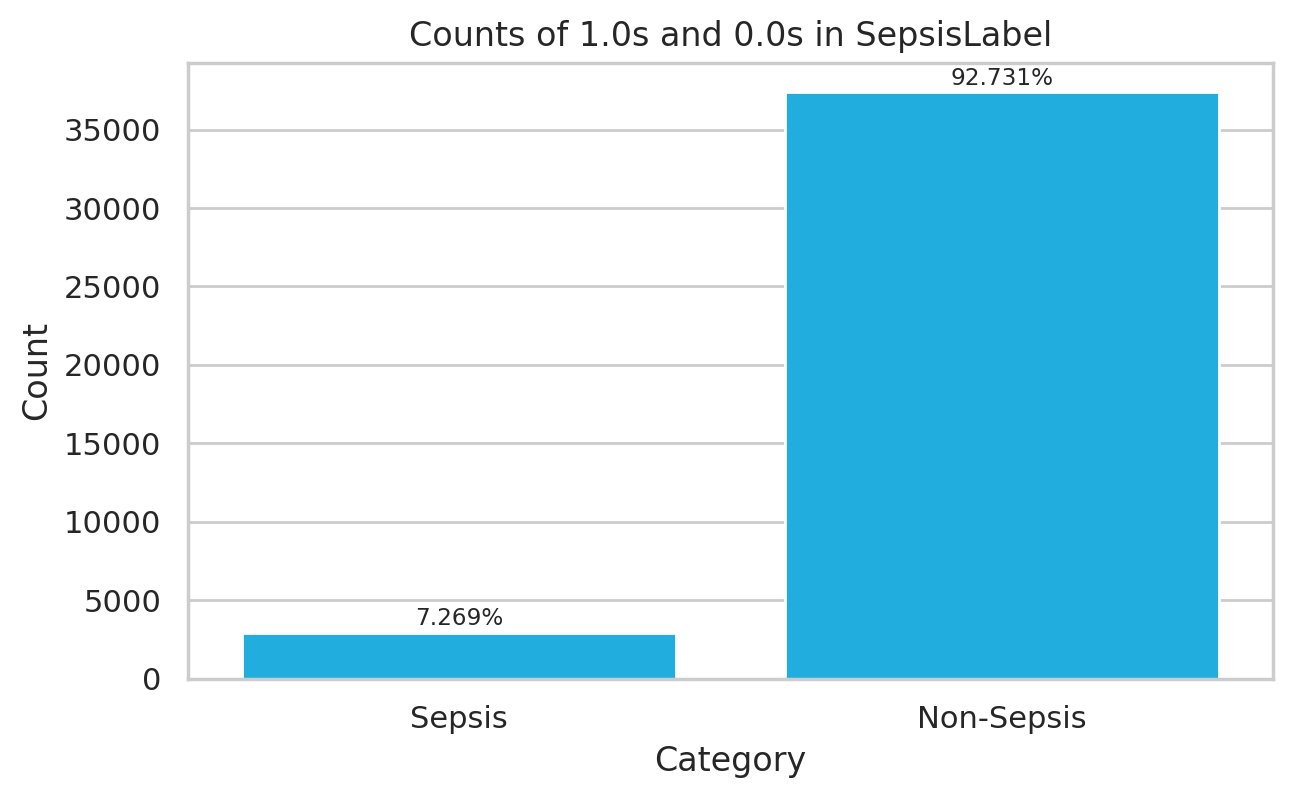

In [5]:
plot_target_classes()

- **Immbalanced Dataset**

## Distribution of recordings

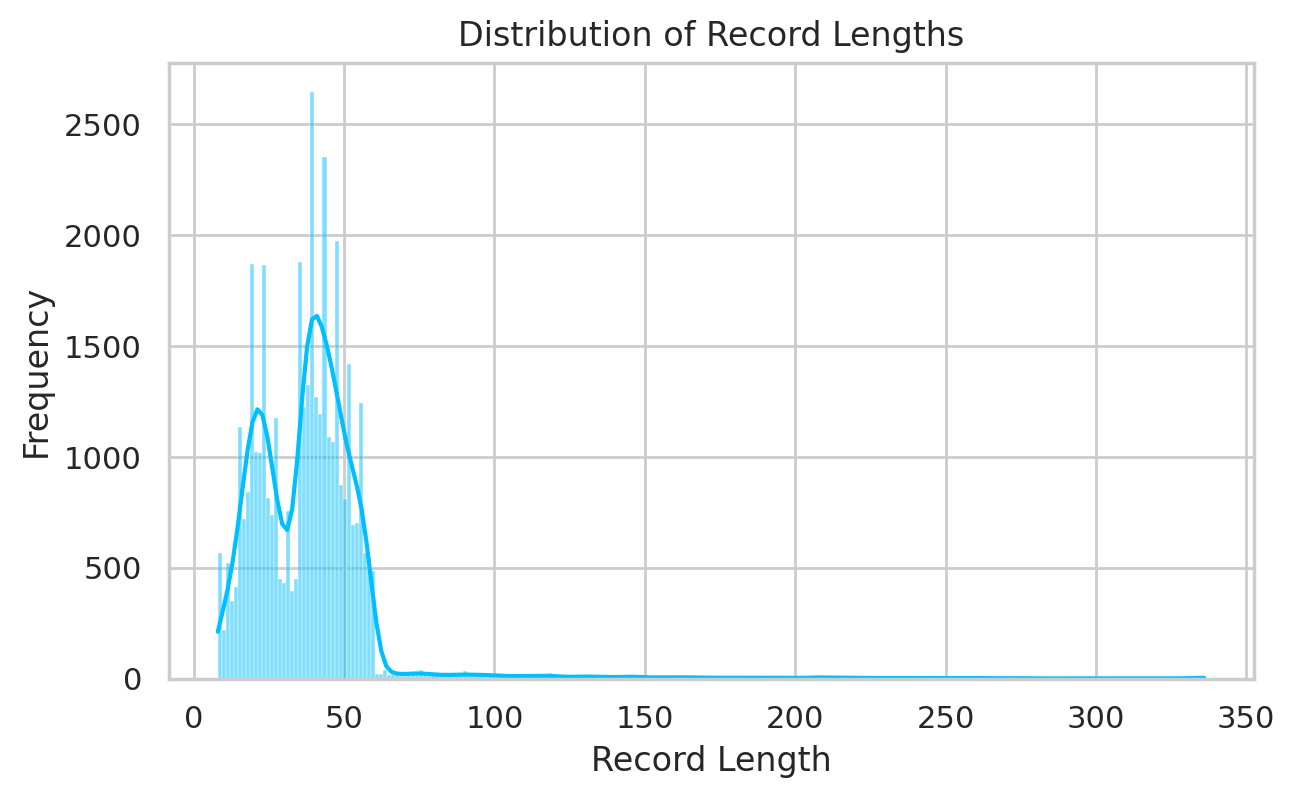

In [6]:
def plot_recordings(record_lengths):
    sns.histplot(record_lengths, kde=True)
    plt.title('Distribution of Record Lengths')
    plt.xlabel('Record Length')
    plt.ylabel('Frequency')
    plt.show()
    
plot_recordings(record_lengths)

- **259 Recordings: p000009**<br>
- **337 Recordings: p016581, p003658**
- **336 Recordings: p018823**

## Missing Values

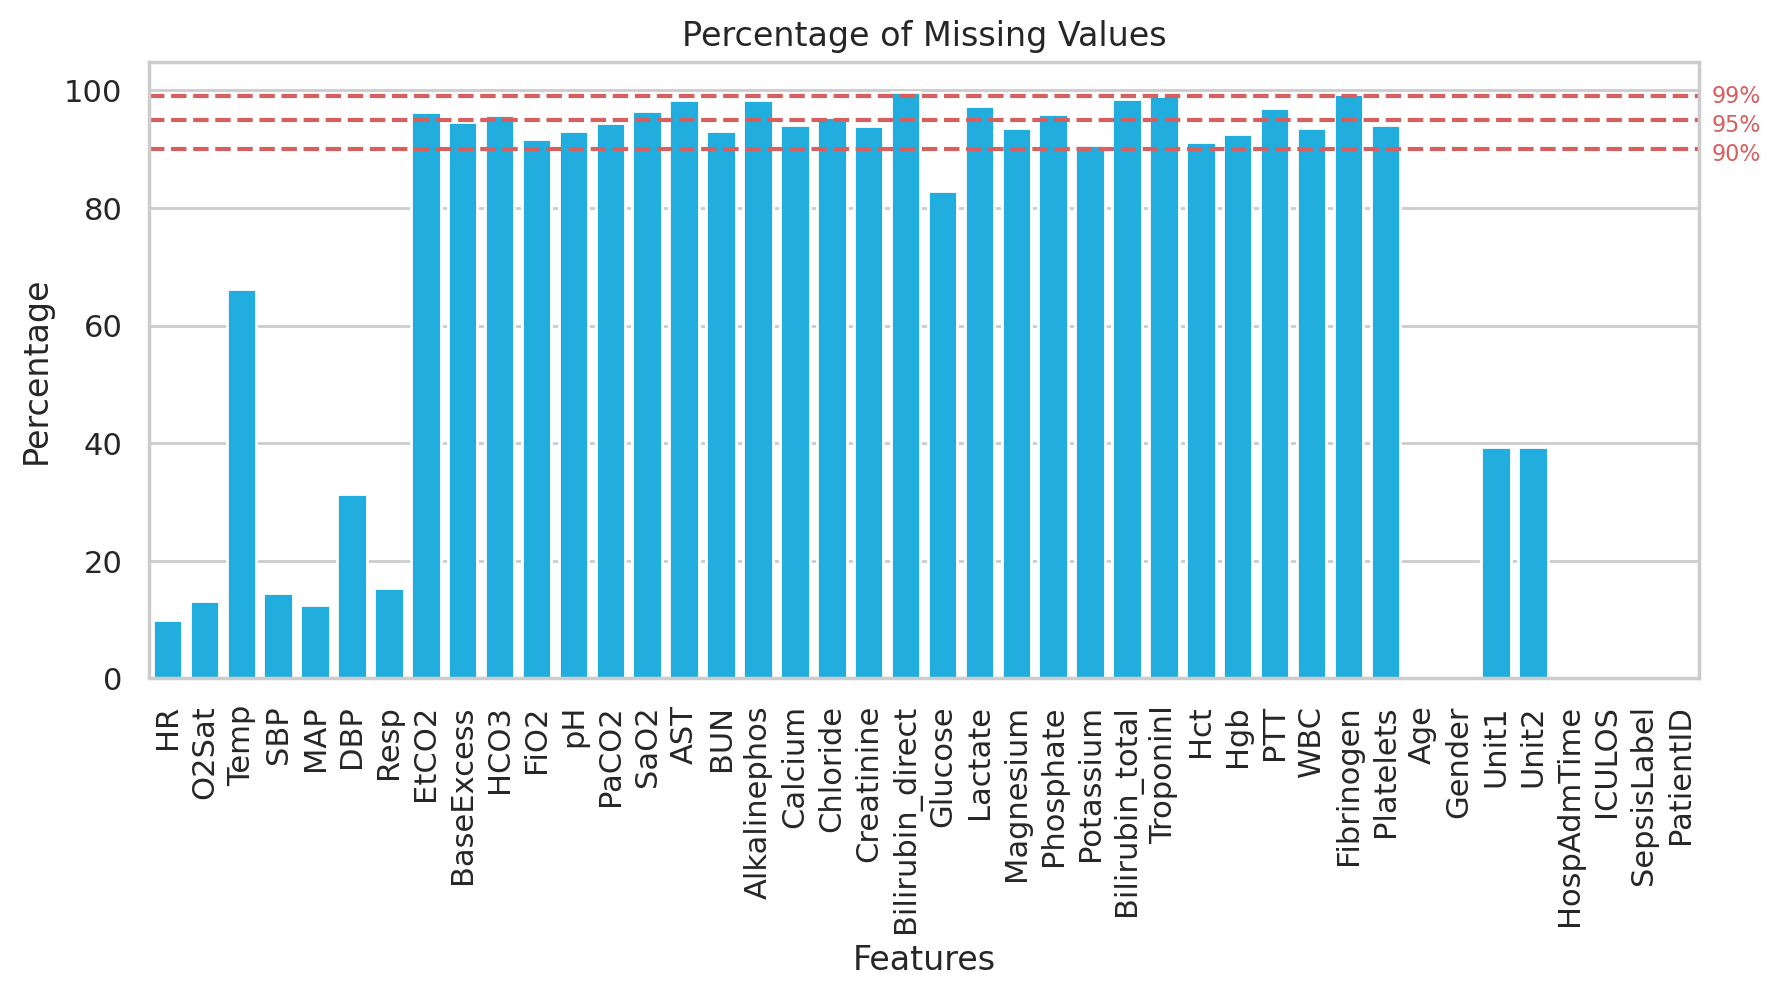

In [7]:
def missing_percentage(dataset):
    
    missing_percent = dataset.isnull().mean() * 100
    missing_df = pd.DataFrame({
        'Features': missing_percent.index,
        'Percentage': missing_percent.values
    })
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x='Features', y='Percentage', data=missing_df)
    plt.title('Percentage of Missing Values')
    plt.xticks(rotation=90)
    plt.axhline(90, color='r', linestyle='--')
    plt.axhline(95, color='r', linestyle='--')
    plt.axhline(99, color='r', linestyle='--')
    plt.text(42.5, 88, '90%', color='r', ha='center', fontdict={'size': 8})
    plt.text(42.5, 93, '95%', color='r', ha='center', fontdict={'size': 8})
    plt.text(42.5, 98, '99%', color='r', ha='center', fontdict={'size': 8})
    
    plt.show()
    
missing_percentage(dataset)

- **Most of the features have above 90% missing values**

In [8]:
vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
laboratory_values = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 
                     'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 
                     'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets']
demographics = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

print(f"Total number of features: {len(vital_signs) + len(laboratory_values) + len(demographics)}")

Total number of features: 40


- **Among vital signs features, EtCO2 has >95% of missing values.**<br>
- **All laboratory features have missing values >90%.**<br>
- **Among demographics features, Unit 1 and Unit 2 has around 40% of missing values.**

### Case 1: Removing features having missing values >90%

In [9]:
# vital_signs.remove('EtCO2')
# laboratory_values = [] # removing all
# demographics = demographics

vital_signs, laboratory_values, demographics = get_features(case=1)
dataset = dataset[vital_signs + laboratory_values + demographics + ['SepsisLabel', 'PatientID']]

Total number of features: 13


In [10]:
print(dataset.shape)
dataset.head()

(1552210, 15)


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,PatientID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.02,1.0,NaN,NaN,-0.03,1.0,0.0,0
1,70.0,97.5,NaN,96.0,62.5,52.5,21.5,83.02,1.0,NaN,NaN,-0.03,2.0,0.0,0
2,72.0,98.0,37.67,119.0,81.0,62.0,22.0,83.02,1.0,NaN,NaN,-0.03,3.0,0.0,0
3,81.0,97.0,NaN,136.0,98.0,74.0,18.0,83.02,1.0,NaN,NaN,-0.03,4.0,0.0,0
4,86.0,NaN,NaN,104.0,71.0,56.5,20.5,83.02,1.0,NaN,NaN,-0.03,5.0,0.0,0


/home/cis/Documents/SepsisEarlyPrediction/utils/helpers.py:153: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_data = patient_data.fillna(method=fill_method)


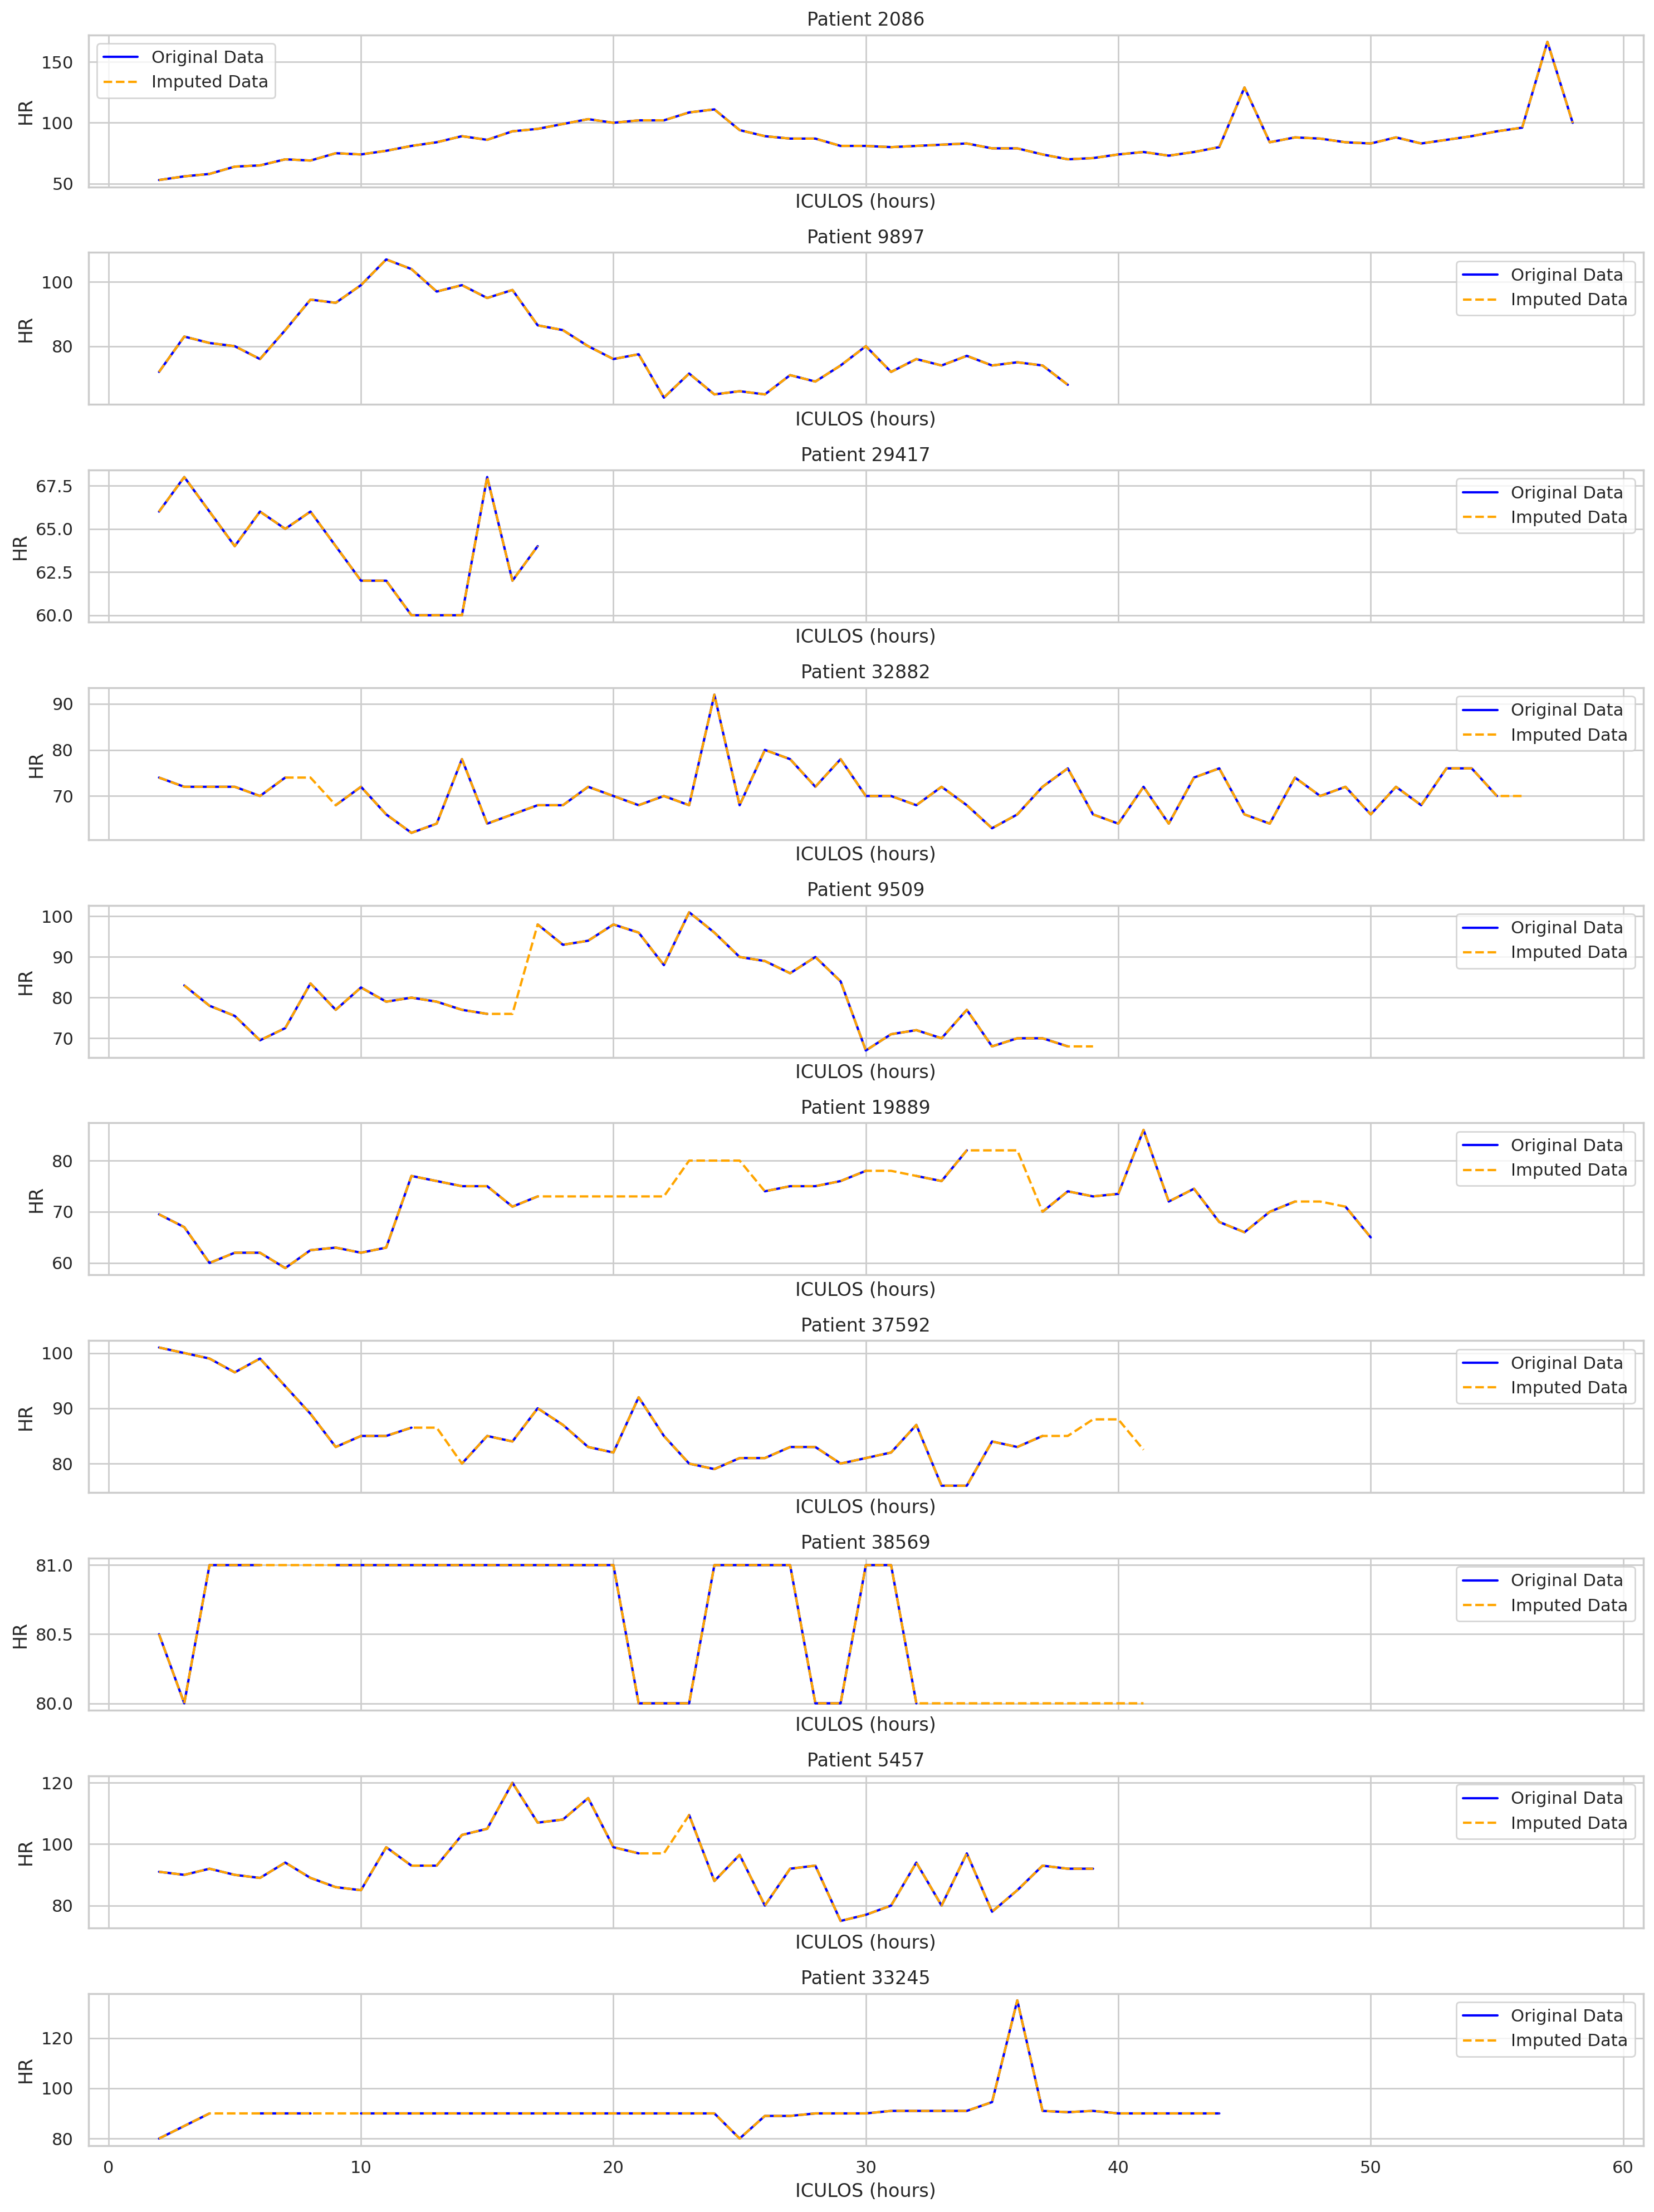

In [11]:
selected_patient_ids = plot_random_patient_recordings(dataset, feature='HR', num_plots=10, fill_method='ffill')